# Descripció del Projecte

Aquest projecte té com a objectiu analitzar i predir accions administratives utilitzant tècniques de processament de llenguatge natural (NLP) i aprenentatge automàtic. A continuació, es descriuen els passos i tècniques utilitzades en l'anàlisi.

## Importació de Llibreries

S'importen les llibreries necessàries per a l'anàlisi de dades, processament de text, i modelatge predictiu, incloent pandas, sklearn, gensim, matplotlib, seaborn, entre altres.

In [59]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold

## Càrrega i Preprocessament de Dades

1. **Càrrega de Dades**: Es carreguen les dades des d'arxius CSV.
2. **Mostreig**: Es pren una mostra aleatòria de 80,000 registres per a l'anàlisi.
3. **Fusió de Dades**: Es fusionen dos dataframes en base a una clau comuna.
4. **Transformació de Dates**: S'extreuen característiques temporals com any, mes, hora i dia de la setmana.
5. **Estandardització**: S'estandarditzen les noves columnes utilitzant MinMaxScaler.
6. **Codificació de Variables**: Es codifiquen variables categòriques com 'Representat' i 'Usuari'.

In [60]:
from sklearn.preprocessing import MinMaxScaler


file_path = '../../accions.csv'
file_path2 = '../../tramits.csv'
# Load the CSV file
df = pd.read_csv(file_path)

# Sample 10000 random rows from the dataframe
df = df.sample(n=100000, random_state=42)
#df = df[df['Usuari'].notnull()]
#df = df[df['Accio'].notnull()]
df_tramits = pd.read_csv(file_path2)

# Merge the two dataframes on 'Tramit' and 'id'
df = pd.merge(df, df_tramits, left_on='Tramit', right_on='Id', how='inner')

df['Data'] = pd.to_datetime(df['Data'])

df['Año'] = df['Data'].dt.year
df['Mes'] = df['Data'].dt.month
df['Hora'] = df['Data'].dt.hour
df['Día de la semana'] = df['Data'].dt.weekday  # 0 = Lunes, 6 = Domingo

# Estandarizar las nuevas columnas
scaler = MinMaxScaler()
df[['Año', 'Mes', 'Hora', 'Día de la semana']] = scaler.fit_transform(df[['Año', 'Mes', 'Hora', 'Día de la semana']])

df['Representat'] = df['Representat'].apply(lambda x: 1 if pd.notnull(x) else 0)
df['Usuari'] = df['Usuari'].apply(lambda x: 1 if pd.notnull(x) else 0)

df = df.drop(columns=['Id', 'Sessio','Tramit','Data'])
# Normalize the titles by converting them to lowercase

## Generació d'Embeddings

S'utilitzen models de Word2Vec per generar representacions vectorials dels títols de les accions. Aquestes representacions es normalitzen i s'integren al dataframe principal. Utilitzem vectors de 30 paràmetres (escollits experimentalment).

In [61]:
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
sentences = df['Titol'].apply(lambda x: x.split())
model = Word2Vec(sentences, vector_size=30, window=5, min_count=1, workers=4)

def get_sentence_vector(sentence):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

df_embeddings = pd.DataFrame(df['Titol'].apply(get_sentence_vector).to_list())

scaler = MinMaxScaler()

# Estandarizar las representaciones vectoriales
df_embeddings_standardized = scaler.fit_transform(df_embeddings)

# Convertir el resultado de nuevo a un DataFrame si lo necesitas
df_embeddings = pd.DataFrame(df_embeddings_standardized)
# Imprimir las primeras filas del DataFrame con las representaciones vectoriales
df_embeddings.columns = [str(i) for i in range(df_embeddings.shape[1])]
print(df_embeddings.head())

          0         1         2         3         4         5         6  \
0  0.380143  0.710461  0.523665  0.619582  0.408366  0.391517  0.560891   
1  0.949595  0.690441  0.180321  0.469048  0.876994  0.194153  0.591035   
2  0.651313  0.408534  0.529656  0.763356  0.080747  0.330190  0.376398   
3  0.760347  0.810866  0.362867  0.731949  0.482709  0.654197  0.541556   
4  0.629586  0.669642  0.459180  0.414553  0.729469  0.475378  0.775194   

          7         8         9  ...        20        21        22        23  \
0  0.584967  0.294820  0.510790  ...  0.458827  0.463343  0.304588  0.240394   
1  0.375820  0.890986  0.268110  ...  0.580947  0.620470  0.426035  0.025030   
2  0.509594  0.401451  0.695971  ...  0.817662  0.744364  0.465931  0.325976   
3  0.804283  0.350152  0.387184  ...  0.428122  0.418407  0.440110  0.563700   
4  0.537140  1.000000  0.724724  ...  0.553617  0.475843  0.877890  0.332856   

         24        25        26        27        28        29  
0  0

In [62]:
dfnou = df.drop(columns=['Titol'])
dfnou = pd.concat([dfnou, df_embeddings], axis=1)
dfnou['Vigent'] = dfnou['Vigent'].apply(lambda x: 1 if x else 0)

## Divisió de Dades

Es divideix el conjunt de dades en conjunts d'entrenament i prova. A més, s'utilitza KFold per realitzar validació creuada.

In [63]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

le = LabelEncoder()
y = le.fit_transform(dfnou['Accio'])
print(y)
X = dfnou.drop(['Accio', 'Usuari','Vigent'], axis=1)

print(pd.Series(y).value_counts())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

first_row_X_test = X_test.iloc[0]

first_row_json = first_row_X_test.to_json()
print(first_row_json)

kf = KFold(n_splits=4, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y[train_index], y[test_index]
    
    smote = SMOTE(random_state=42)
    X_train_kf_resampled, y_train_kf_resampled = smote.fit_resample(X_train_kf, y_train_kf)
    
    print(f"TRAIN: {train_index}, TEST: {test_index}")
    print(f"X_train_kf_resampled shape: {X_train_kf_resampled.shape}, X_test_kf shape: {X_test_kf.shape}")
    print(f"y_train_kf_resampled shape: {y_train_kf_resampled.shape}, y_test_kf shape: {y_test_kf.shape}")


[1 1 1 ... 0 0 0]
0    72409
1    23533
2     4058
Name: count, dtype: int64
{"Representat":0.0,"A\u00f1o":0.625,"Mes":0.1818181818,"Hora":0.5217391304,"D\u00eda de la semana":0.3333333333,"0":0.9042155743,"1":0.556935668,"2":0.471393615,"3":0.532684207,"4":0.552739501,"5":0.5571280718,"6":0.4061531425,"7":0.6153420806,"8":0.7215601802,"9":0.4410313964,"10":0.1561380476,"11":0.441878438,"12":0.6688673496,"13":0.6371874809,"14":0.5321704149,"15":0.3272645473,"16":0.3920966685,"17":0.3818346262,"18":0.6972008348,"19":0.2641135156,"20":0.7652056813,"21":0.4598801732,"22":0.3441657424,"23":0.7971709967,"24":0.7034292221,"25":0.6763036251,"26":0.6450250149,"27":0.3727389574,"28":0.239730835,"29":0.4945113659}
TRAIN: [    0     1     2 ... 99995 99997 99998], TEST: [    8    23    39 ... 99993 99996 99999]
X_train_kf_resampled shape: (163023, 35), X_test_kf shape: (25000, 35)
y_train_kf_resampled shape: (163023,), y_test_kf shape: (25000,)
TRAIN: [    0     1     2 ... 99997 99998 99999], TE

## Modelatge Predictiu

1. **Models Utilitzats**: S'utilitzen models com LightGBM i RandomForestClassifier.
2. **Balanceig de Dades**: S'utilitza SMOTE per balancejar les classes en les dades d'entrenament.
3. **Entrenament i Validació**: S'entrena i valida el model utilitzant KFold i s'avaluen els resultats amb mètriques com la matriu de confusió i l'informe de classificació.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6775
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 35
[LightGBM] [Info] Start training from score -0.322209
[LightGBM] [Info] Start training from score -1.448056
[LightGBM] [Info] Start training from score -3.208266
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6769
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 35
[LightGBM] [Info] Start training from score -0.324383
[LightGBM] [Info] Start training from score -1

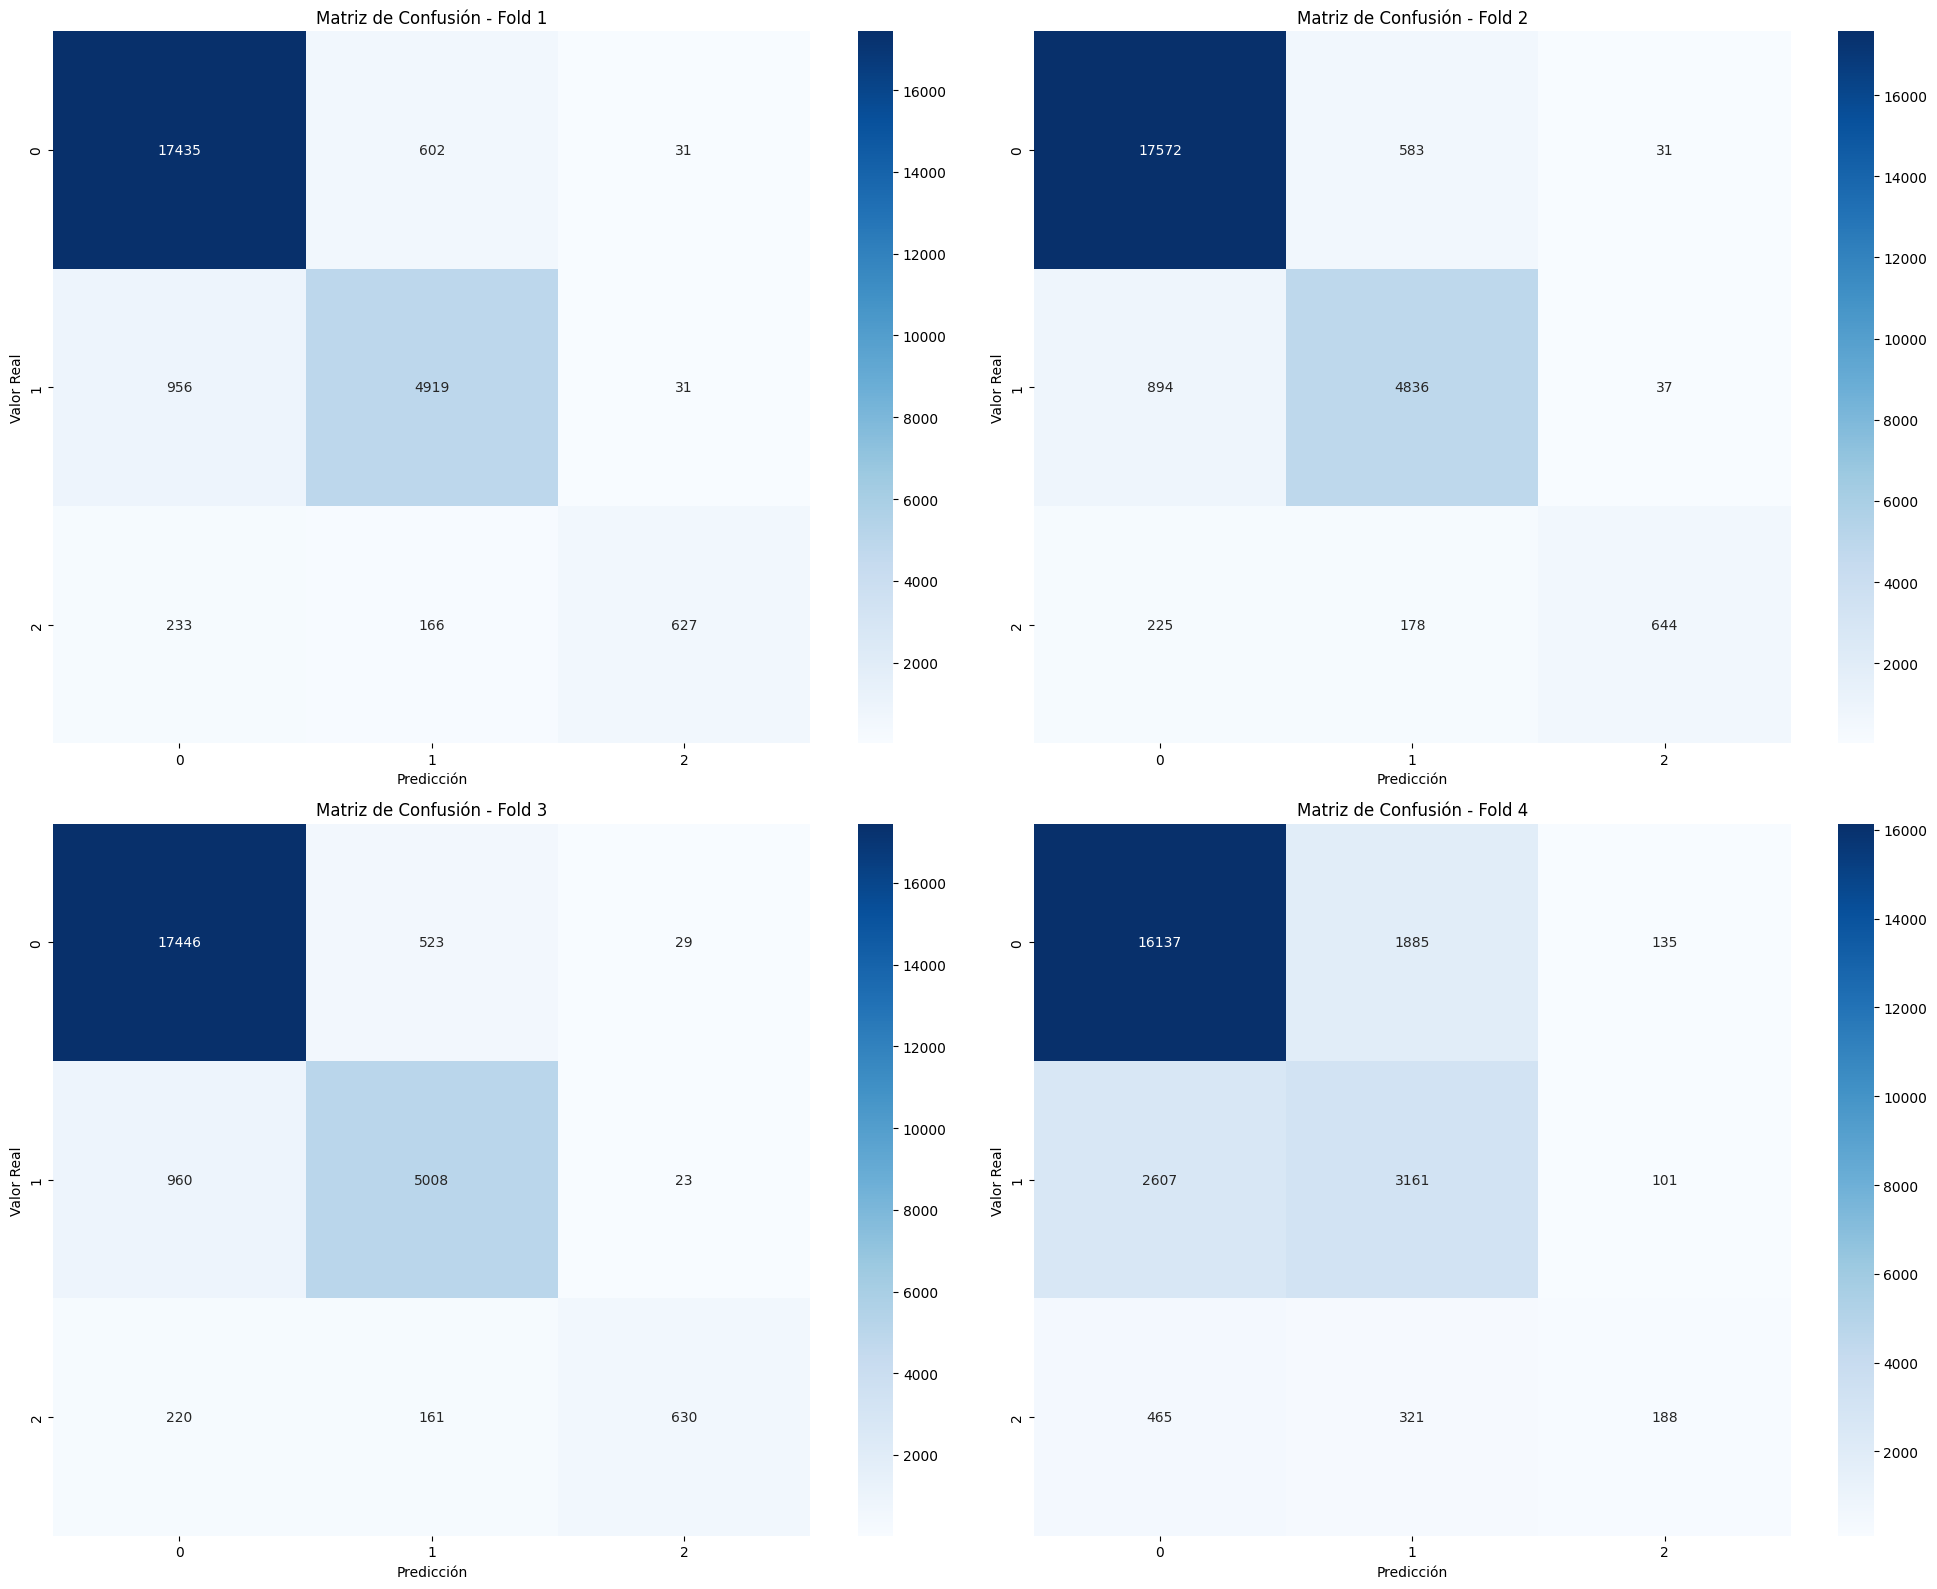

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV


model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    random_state=42,
    n_jobs=-1,
    num_leaves=63,
    learning_rate=0.2,
    n_estimators=500,
    min_child_samples=10,
    max_depth=-1,
    subsample=1.0
)

lst = []
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y[train_index], y[test_index]
    
    model.fit(X_train_kf, y_train_kf)
    lst.append(model)
    y_pred_kf = model.predict(X_test_kf)
    
    #print(f"Fold results:\n{classification_report(y_test_kf, y_pred_kf)}")

fig, axes = plt.subplots(2, 2, figsize=(20, 16))

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y[train_index], y[test_index]
    
    y_pred_kf = lst[i].predict(X_test_kf)
    
    cm = confusion_matrix(y_test_kf, y_pred_kf)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Matriz de Confusión - Fold {i+1}')
    axes[i//2, i%2].set_ylabel('Valor Real')
    axes[i//2, i%2].set_xlabel('Predicción')

plt.tight_layout()
plt.show()

## Ensamblatge de Models

Es crea un classificador d'ensamblatge utilitzant votació majoritària per combinar les prediccions de múltiples models.

Precisión final después de fusionar predicciones: 0.9192


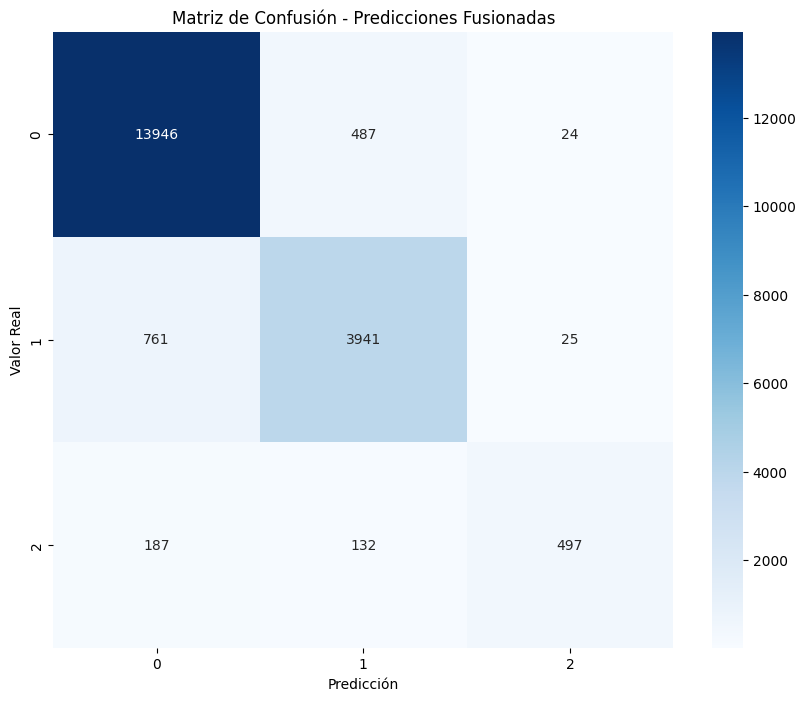

In [65]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = []

for model in lst:
    y_pred = model.predict(X_test)  # Predicción para cada modelo
    predictions.append(y_pred)

# Fusionar las predicciones utilizando votación mayoritaria (para clasificación)
predictions = np.array(predictions).T  # Transponer para tener una fila por muestra
fused_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=predictions)

# Evaluación de las predicciones fusionadas
accuracy = accuracy_score(y_test, fused_predictions)
print(f'Precisión final después de fusionar predicciones: {accuracy}')

# Matriz de confusión para las predicciones fusionadas
cm_fused = confusion_matrix(y_test, fused_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_fused, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Predicciones Fusionadas')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()


## Avaluació Final

S'avaluen les prediccions finals utilitzant precisió i matriu de confusió per mesurar el rendiment del model d'ensamblatge.

In [66]:
import numpy as np
import joblib
from sklearn.base import BaseEstimator, ClassifierMixin

class VotingEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        # Los modelos ya están fiteados, así que no hacemos nada aquí
        return self
    
    def predict(self, X):
        # Obtener predicciones de todos los modelos
        predictions = [model.predict(X) for model in self.models]
        
        # Fusionar las predicciones usando votación mayoritaria (para clasificación)
        predictions = np.array(predictions).T  # Transponer para tener una fila por muestra
        fused_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=predictions)
        
        return fused_predictions

ensemble_model = VotingEnsembleClassifier(models=lst)


## Guardat del Model

El model final es guarda en un arxiu utilitzant joblib per al seu ús futur.

In [67]:
import joblib

#joblib.dump(ensemble_model, 'model_accio_5M.joblib')